<a href="https://colab.research.google.com/github/itamar108/os/blob/master/DQN_RL2024_FinalProject_ENV2_KeyDoorEnv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid Semester Project - DEEP Reinforcements Learning
# ENV2 - KEY DOOR ENVIRONMENT
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Itamar Hadad. ID: 308426964
<br>
Student 2: Neriya Shulman. ID: 208275024
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Pre-Requisit

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque


import torch
import torch.nn as nn
import torch.nn.functional as F


from collections import deque, namedtuple
import torch.optim as optim



Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

#Env2 - Key Door Env

## Class Env

In [ ]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random

class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
            return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

## WRAPPER

In [ ]:

ACTION_MAP = {0:0,
              1:1,
              2:2,
              3:3,
              4:5,
              5:5}


class KEYRGBImgObsWrapper(gym.core.ObservationWrapper):
    """
    Wrapper to use fully observable RGB image as the only observation output,
    no language/mission. This can be used to have the agent to solve the
    gridworld in pixel space.
    """

    def __init__(self, env, tile_size=32, plot=False, preprocess= lambda x: x):
        super().__init__(env)

        self.tile_size = tile_size
        self.plot = plot
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            # #the default is (320,320,3). Tile size  = 32 X 10 (grid size)
            # TODO: BE CAREFULL TO CHANGE the shape size to be according your preprocess size/channels
            # The env information i staken from here
            shape=(320, 320, 3),
            dtype='uint8'
        )
        self.prev_door = False
        self.prev_key = False
        self.action_space = spaces.Discrete(self.action_space.n - 2)

        #TODO: THINK AND TEST DIFFERENT PREPROCESS
        self._preprocess = lambda x: x


    def observation(self, obs):
      env = self.unwrapped

      # Call render without any unsupported keyword arguments
      rgb_img = env.render()  # Use the default rendering behavior
      return rgb_img

    def reset(self, seed = 0, options = None):
        self.prev_door = False
        self.prev_key = False
        obs, info = super().reset()
        if self.plot:
            plt.show()
        return self._preprocess(obs), info

    def step(self, action):
        action = ACTION_MAP[action]
        obs, r, d, info, x = super().step(action)
        obs = self._preprocess(obs)

        # TODO: REWARD SHAPING
        #we encourage you to come up with a better reward function using  self.is_door_open() and self.is_carrying_key()

        r = self.reshape_reward(r)


        return obs, r, d, info, x

    def reshape_reward(self, r):
        x_pos, y_pos = self.agent_pos

        if r > 0:
            return r*15

        if x_pos > 2:
            # print("pass the wall")
            return -0.08

        if self.env.is_door_open():
            return -0.2

        if self.env.is_carrying_key():
            return -0.5

        return -1



## Env Info

(320, 320, 3)


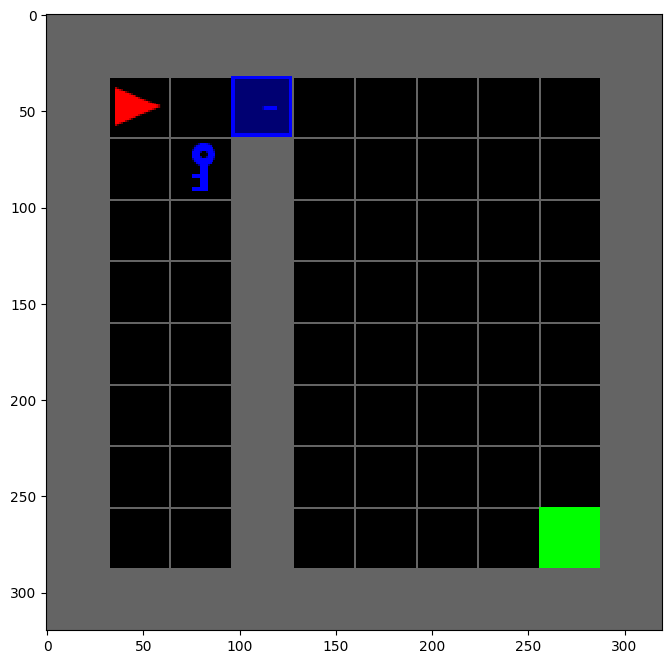

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()[0]
print(obs.shape)
screen = env.render()

plt.imshow(screen)

In [ ]:
state_size = obs.shape  # Replace with your actual state size
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")
print(f"State size is: {state_size}")

Number of actions: 5
State size is: (320, 320, 3)


## Random action

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, _, _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

# Our Solution:

### Utils

In [ ]:
def play_game_and_create_video(agent, video_output_file_name):
  env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
  env = PreprocessWrapper(env)
  obs = env.reset()[0]
  max_steps = 100
  # Evaluation
  with imageio.get_writer(video_output_file_name, fps=10) as video:
    obs = env.reset()[0]
    state = obs
    done = False
    total_reward = 0
    for step in range(max_steps):
        action = agent.act(state)
        obs, reward, done, _, _ = env.step(action)
        state = obs  # Get agent's position directly from the environment
        video.append_data(env.render())
        if done:
          print("done","reward=", total_reward,"num_of_steps=",step)
          break


### Preproccessing

In [ ]:

class PreprocessWrapper(gym.ObservationWrapper):
    def __init__(self, env, resize_shape=(144, 144)):
        super(PreprocessWrapper, self).__init__(env)
        self.resize_shape = resize_shape

         # Define observation space after preprocessing
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self.resize_shape[0], self.resize_shape[1], 1),  # Grayscale image
            dtype=np.uint8
        )

    def observation(self, obs):
        # Convert RGB to grayscale
        # print(f'obs.shape {obs.shape}')
        cropped_obs = obs[32:-31, 32:-31]
        # print(f'cropped obs.shape {cropped_obs.shape}')
        obs_gray = cv2.cvtColor(cropped_obs, cv2.COLOR_RGB2GRAY)
        # print(f'obs_gray.shape {obs_gray.shape}')
        # Resize image


        red_mask = np.all(cropped_obs == [0, 0, 255], axis=-1)  # Check for red pixels (BGR format)
        blue_mask = np.all(cropped_obs == [255, 0, 0], axis=-1)  # Check for blue pixels (BGR format)
        obs_gray[red_mask] = 100  # Replace red pixels with 0
        obs_gray[blue_mask] = 255  # Replace blue pixels with 0

        obs_resized = cv2.resize(obs_gray, self.resize_shape)

        # Add channel dimension to make it (H, W, 1)
        obs_resized = np.expand_dims(obs_resized, axis=0)
        # print(obs_resized.shape)
        return obs_resized


    def step(self, action):
        obs, reward, done, info, _ = self.env.step(action)
        obs = self.observation(obs)
        # reward = self.shape_reward(reward)
        return obs, reward, done, info, _

obs.shape is (320, 320, 3)
obs.shape is (1, 144, 144)


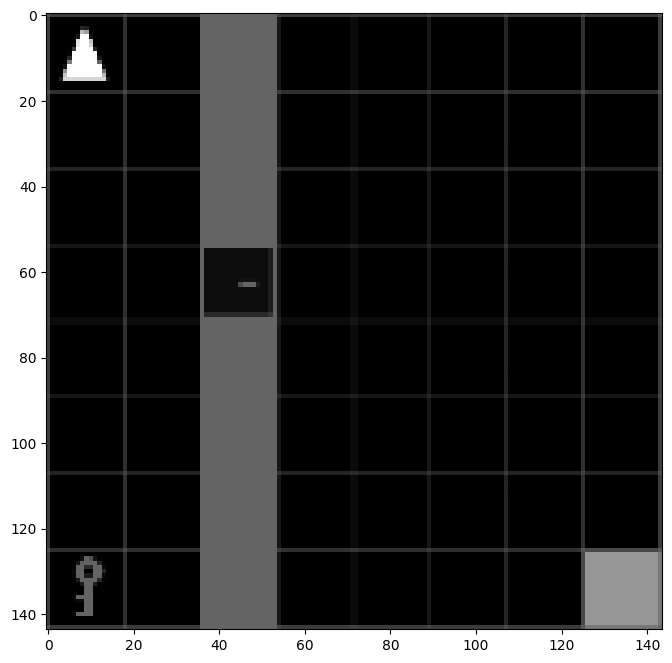

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()[0]

print(f'obs.shape is {obs.shape}')
env = PreprocessWrapper(env)
obs = env.reset()[0]
obs = env.step(0)[0]
print(f'obs.shape is {obs.shape}')
plt.imshow(obs[0], cmap='gray')

In [ ]:
state_size = obs.shape  # Replace with your actual state size
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")
print(f"State size is: {state_size}")
action_size = num_actions

Number of actions: 5
State size is: (1, 144, 144)


### Network

In [ ]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        print(state_size)
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        zeros = torch.zeros(1, *state_size)
        print(f'zeros.shape: {zeros.shape}')
        conv_out_size = self.conv(zeros).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )

    def forward(self, state):
        """Build a network that maps state -> action values."""
        # print(f'state.shape: {state.shape}')
        # print(f'self.conv(state): {self.conv(state).shape}')
        # print(f'self.conv(state).view(state.size()[0], -1): {self.conv(state).view(state.size()[0], -1).shape}')

        conv_out = self.conv(state).view(state.size()[0], -1)
        return self.fc(conv_out)

model = QNetwork(state_size, action_size, 0)
print(model)

(1, 144, 144)
zeros.shape: torch.Size([1, 1, 144, 144])
QNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=12544, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)


In [ ]:
#BUFFER SIZE VERY IMPORTANT TO BE LARGE FOR CONVERGENCE
REPLAY_BUFFER_SIZE =    10000    #@param {type:"number"}
BATCH_SIZE         =    64       # minibatch size
GAMMA              =    0.9     # discount factor
SOFT_UPDATE_RATE   =    1e-3     # for soft update of target parameters
LEARNING_RATE      =    5e-4     # learning rate
UPDATE_EVERY       =    5        #@param {type:"slider", min:5, max:50}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


###Agent

In [ ]:
class ReplayBuffer:

  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)

  def add(self, state, action, reward, next_state, done):
    e = self.experience(state, action, reward, next_state, done)
    self.memory.append(e)

  def sample(self):
    experiences = random.sample(self.memory, k=self.batch_size)

    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    return len(self.memory)

In [ ]:
#Agent

class Agent():
  def __init__(self, state_size, action_size, seed):
    """Initialize an Agent object.

    Params
    ======
        state_size (int): dimension of each state
        action_size (int): dimension of each action
        seed (int): random seed
    """
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)
    # Q-Network
    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)

    # Replay memory
    self.memory = ReplayBuffer(action_size, REPLAY_BUFFER_SIZE, BATCH_SIZE, seed)

    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    """Save experience in replay memory, and use random sample from buffer to learn."""


    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)

    # Learn every UPDATE_EVERY time steps.
    self.t_step = (self.t_step + 1) % UPDATE_EVERY

    if self.t_step == 0:
      # If enough samples are available in memory, get random subset and learn
      if len(self.memory) > BATCH_SIZE:
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

  def act(self, state, eps=0.):
    """Returns actions for given state as per current policy.

    Params
    ======
        state (array_like): current state

        eps (float): epsilon, for epsilon-greedy action selection
    """


    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values = self.qnetwork_local(state)

    self.qnetwork_local.train()

    # e-greedy explore/exploit
    if random.random() > eps:
      return np.argmax(action_values.cpu().data.numpy())

    else:
      return random.choice(np.arange(self.action_size))


  def learn(self, experiences, gamma):
    """Update value parameters using given batch of experience tuples.

    Params
    ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
        gamma (float): discount factor
    """
    states, actions, rewards, next_states, dones = experiences
    # Get max predicted Q values (for next states) from target model

    q_targets_next = self.qnetwork_target(next_states.unsqueeze(dim=1)).detach().max(1)[0].unsqueeze(1)

    # Compute Q targets for current states
    q_targets = rewards + (gamma * q_targets_next * (1 - dones))

    # Get expected Q values from local model
    q_expected = self.qnetwork_local(states.unsqueeze(dim=1)).gather(1, actions)

    loss = F.mse_loss(q_expected, q_targets)
    # loss = nn.HuberLoss(delta=1.0)

    # Minimize the loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, SOFT_UPDATE_RATE)

  def soft_update(self, local_model, target_model, SOFT_UPDATE_RATE):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(SOFT_UPDATE_RATE*local_param.data + (1.0-SOFT_UPDATE_RATE)*target_param.data)



In [ ]:

def dqn(agent, n_episodes=10000, max_t=100, eps_start=1.0, eps_end=0.01, eps_decay=0.995, document_epsiodes=[]):
  scores = []                        # list containing scores from each episode
  scores_window = deque(maxlen=100)  # last 100 scores
  steps_window = deque(maxlen=100)
  steps = []
  eps = eps_start                    # initialize epsilon
  for i_episode in range(1, n_episodes+1):
    initial_state, _ = env.reset()
    state = np.reshape(initial_state, [*state_size])
    score = 0
    step = 0
    for t in range(max_t):
      action = agent.act(state, eps)
      next_state, reward, done, _, _ = env.step(action)
      next_state = np.reshape(next_state, [*state_size])
      agent.step(state, action, reward, next_state, done)
      state = next_state
      score += reward
      if done:
        break
      step += 1

    steps_window.append(step)
    steps.append(step)

    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.8f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.8f}\t Average Steps: {:.3f}\t  Epsilon {:.5f}'.format(i_episode,  np.mean(scores_window), np.mean(steps_window), eps))
    if i_episode in document_epsiodes:
      play_game_and_create_video(agent, f'/content/vid_{i_episode}.mp4')
  return scores, steps

### Training

In [ ]:
agent = Agent(state_size, action_size, seed=0)
scores, steps = dqn(agent,n_episodes=3500, max_t=100, eps_start=1.0, eps_end=0.01, eps_decay=0.9995, document_epsiodes=[500, 1000, 1500])

(1, 144, 144)
zeros.shape: torch.Size([1, 1, 144, 144])
(1, 144, 144)
zeros.shape: torch.Size([1, 1, 144, 144])
Episode 100	Average Score: -89.29600000	 Average Steps: 100.000	  Epsilon 0.95122
Episode 200	Average Score: -87.95460000	 Average Steps: 100.000	  Epsilon 0.90481
Episode 300	Average Score: -80.94720000	 Average Steps: 100.000	  Epsilon 0.86068
Episode 400	Average Score: -73.26680000	 Average Steps: 100.000	  Epsilon 0.81869
Episode 500	Average Score: -66.09060000	 Average Steps: 100.000	  Epsilon 0.77875
Episode 600	Average Score: -62.62800000	 Average Steps: 100.000	  Epsilon 0.74076
Episode 700	Average Score: -54.91460000	 Average Steps: 98.810	  Epsilon 0.70463
Episode 800	Average Score: -53.23920000	 Average Steps: 98.270	  Epsilon 0.67025
Episode 900	Average Score: -38.53580000	 Average Steps: 88.200	  Epsilon 0.63756
Episode 1000	Average Score: -28.42740000	 Average Steps: 82.780	  Epsilon 0.60645
Episode 1100	Average Score: -19.79640000	 Average Steps: 68.500	  Epsil

In [ ]:
np.savetxt('/content/drive/MyDrive/RL_MODELS/OPTIMAL_eps_09995_gamma_09_buffer_10k_scores.txt', np.array(scores), fmt='%d')
np.savetxt('/content/drive/MyDrive/RL_MODELS/OPTIMAL_eps_09995_gamma_09_buffer_10k_steps.txt', np.array(steps), fmt='%d')
torch.save(agent.qnetwork_local.state_dict(), 'OPTIMAL_eps_09995_gamma_09_buffer_10k.pth')

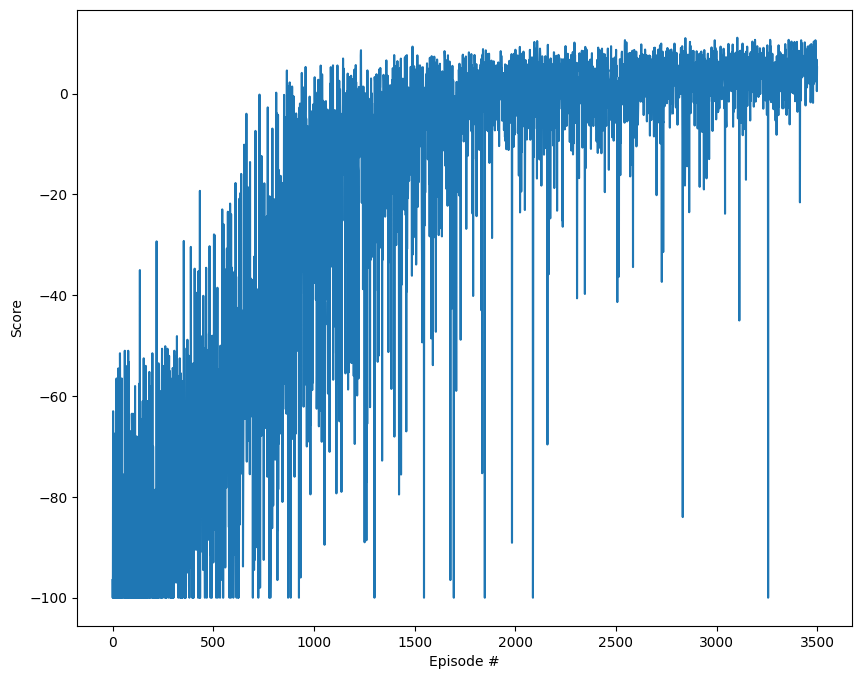

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

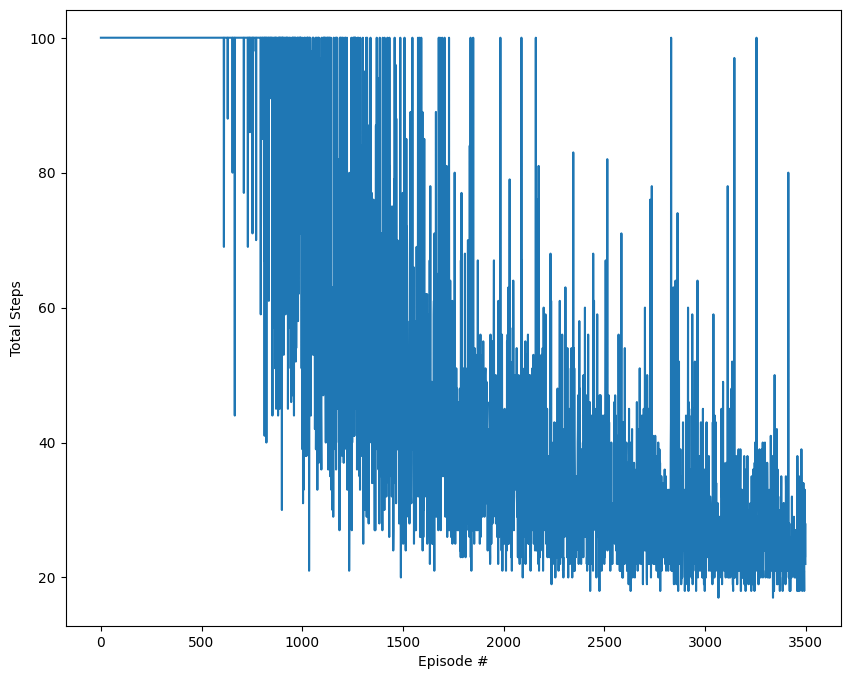

In [ ]:
# plot the steps
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(steps)), steps)
plt.ylabel('Total Steps')
plt.xlabel('Episode #')
plt.show()

## Videos

In [ ]:
agent.qnetwork_local.eval()  # Set the network to evaluation mode if you're using it for inference

QNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=12544, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)

### Video with trained solver

In [ ]:
play_game_and_create_video(agent, '/content/vid_trained.mp4')
embed_mp4('/content/vid_trained.mp4')

done reward= 0 num_of_steps= 26


### Videos from training in progress

#### Video after 500 episodes training

In [ ]:
embed_mp4('/content/vid_500.mp4')

#### Video after 1000 episodes training

In [ ]:
embed_mp4('/content/vid_1000.mp4')

#### Video after 1500 episodes training

In [ ]:
embed_mp4('/content/vid_1500.mp4')

## Evaluating average step count

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
env = PreprocessWrapper(env)
obs = env.reset()[0]

steps_per_episodes = []
num_of_games = 100
# Evaluation
for i in range (num_of_games):
  obs = env.reset()[0]
  step_count = 0
  state = obs
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = agent.act(state)
      obs, reward, done, _, _ = env.step(action)
      step_count += 1
      state = obs  # Get agent's position directly from the environment
      if done:
        break

  steps_per_episodes.append(step_count)

avg = sum(steps_per_episodes)/len(steps_per_episodes)
print(f'avg is {avg}')
median = np.median(steps_per_episodes)
print(f'median is {median}')

avg is 21.36
median is 19.0


## Loading saved model for inference

In [ ]:
MODEL_PATH = 'OPTIMAL_eps_09995_gamma_09_buffer_10k.pth'
agent = Agent(state_size, action_size, seed=0)
agent.qnetwork_local.load_state_dict(torch.load(MODEL_PATH, map_location=device))
agent.qnetwork_local.eval()  # Set the network to evaluation mode if you're using it for inference

(1, 144, 144)
zeros.shape: torch.Size([1, 1, 144, 144])
(1, 144, 144)
zeros.shape: torch.Size([1, 1, 144, 144])


QNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=12544, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)